In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import scanpy as sc
import pickle as pkl

import sys
sys.path.append('../')
from basiss.utils import inverse_dict

In [2]:
%load_ext autoreload
%autoreload 2

## Overview of panel expression
We used two panels for the spatial expression analysis, names <em>exp</em> or <em>Oncology</em> and <em>imm</em> or <em>Immune</em>. The former targets genes involved in proliferation, EMT, invasiveness, stemness, angiogenesis as well as genes for breast cancer subtyping and oncotypeDX recurrence scoring. The latter focuses on immune related genes. However, the exact cell of origin of the targeted genes is unknown and many of genes are expected to express in multiple different cell types

To find out how genes are expressed across cells types commonly found in breast cancer, and investigate if we could pinpoint marker genes to move spatial analysis to the single-cell level, we used previously published breast cancer single-cell atlas (Wu et al. Nature Genetics, 2021) as a reference

In [3]:
# load cancer expression and immune panels
with open('../submission/generated_data/data_structures/data_case1_saved.pkl', 'rb') as file:
    saved_lists = pkl.load(file)
imm_sample_list_case1 = saved_lists['imm_sample_list']
exp_sample_list_case1 = saved_lists['exp_sample_list']

with open('../submission/generated_data/data_structures/data_case2_saved.pkl', 'rb') as file:
    saved_lists = pkl.load(file)
imm_sample_list_case2 = saved_lists['imm_sample_list']
exp_sample_list_case2 = saved_lists['exp_sample_list']

In [4]:
### gene_names aliases
rename_table = pd.read_csv('../submission/external_data/scRNA/gene_rename_table_temp_annot.csv')

unique_imm = np.unique(np.reshape([imm_sample_list_case2[i].genes for i in range(3)] + [imm_sample_list_case1[i].genes for i in range(5)], -1))
unique_exp = np.unique(np.reshape([exp_sample_list_case2[i].genes for i in range(3)] + [exp_sample_list_case1[i].genes for i in range(5)], -1)) 

In [5]:
#load_scrna data
data = sc.read_h5ad('../submission/external_data/scRNA/atals_processed.h5ad')

<b>ED Fig 2C</b> Mean expression of the genes used in ISS immune and oncology panels was calculated from the breast cancer single cell RNA sequencing (scRNA) reference (derived form Wu et al. Nature Genetics, 2021) to aid interpretation of the observed ISS signal distribution.


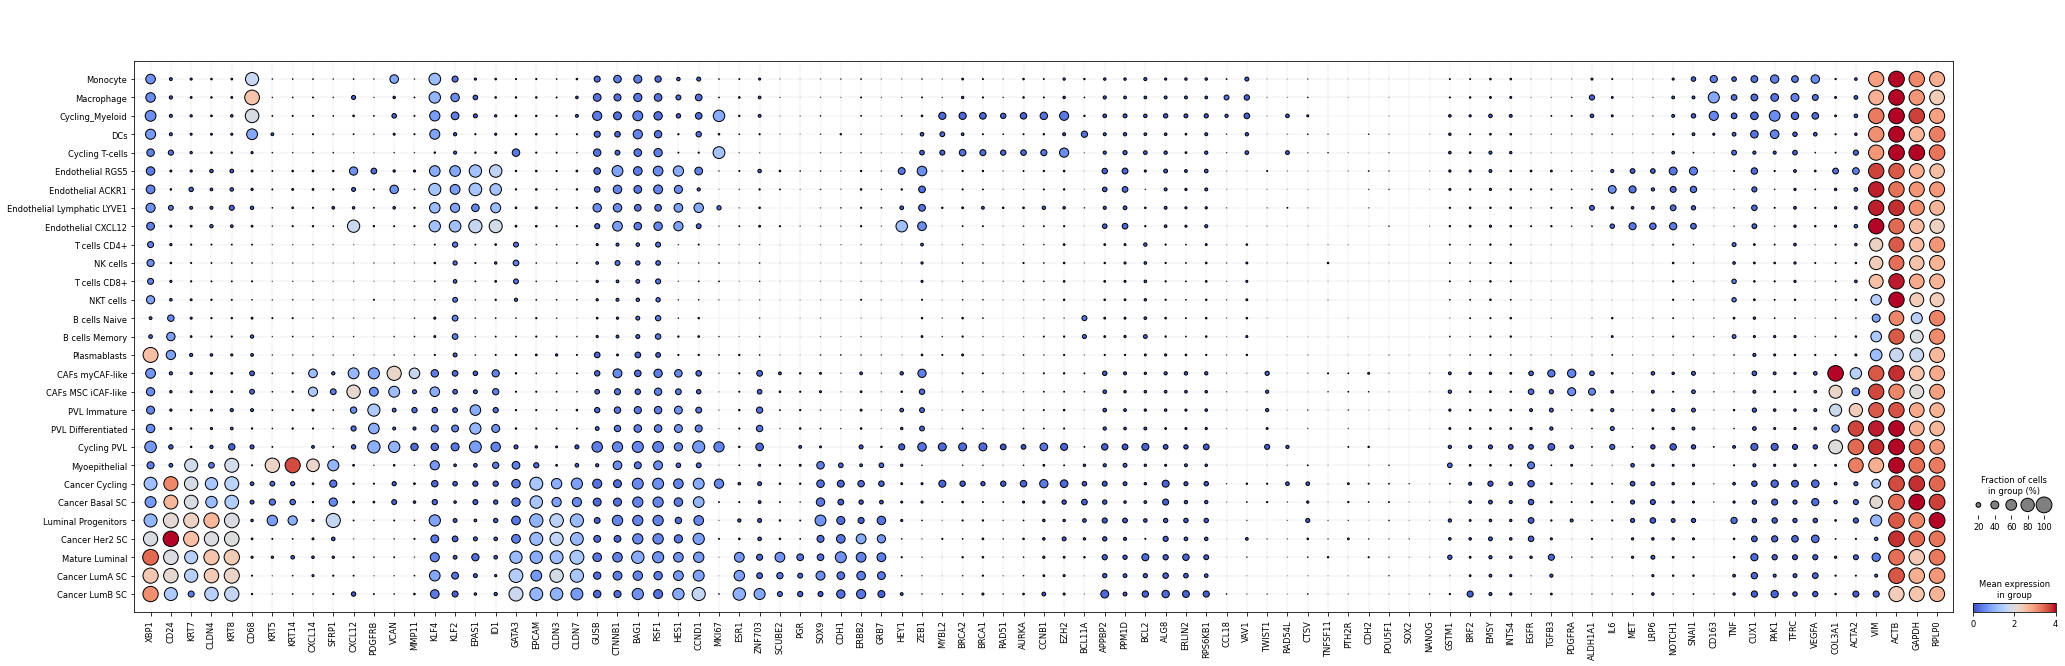

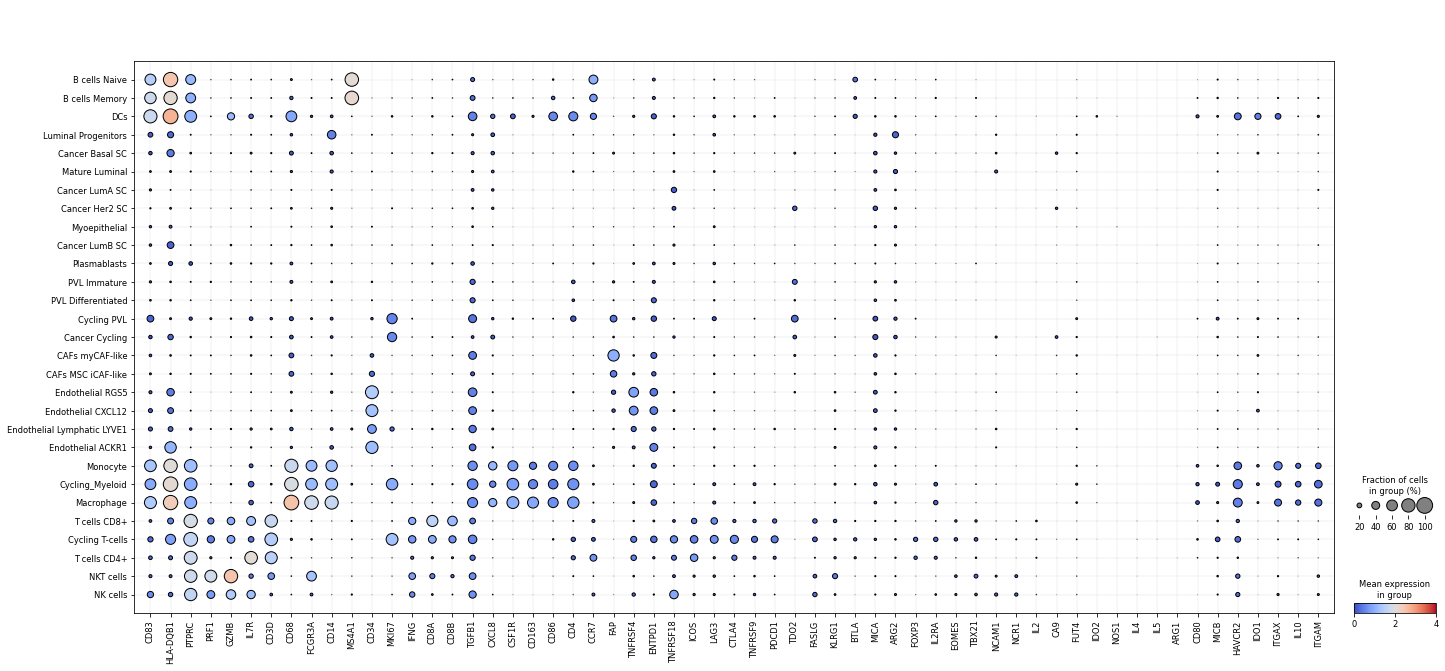

In [6]:
level = 'celltype_minor'
for panel in ['expression_panel', 'immune_panel']:
    markers = rename_table['new'][rename_table[panel]]
    markers = [x.upper() for x in markers]
    data_sub = data[:,data.var.gene_ids.isin(markers)]
    res = pd.DataFrame(columns=data_sub.var_names, index=data_sub.obs[level].cat.categories)                                                                                                 

    for clust in data_sub.obs[level].cat.categories: 
        res.loc[clust] = data_sub[data_sub.obs[level].isin([clust]),:].X.mean(0)

    from scipy.cluster.hierarchy import linkage, dendrogram

    markers = np.array(list(res.T.index))
    categs = np.array(list(res.index))

    d = dendrogram(linkage(res.T, method='complete'), no_plot=True)
    markers_clustered = markers[d['leaves']]

    d = dendrogram(linkage(res, method='complete'), no_plot=True)
    categs_clustered = categs[d['leaves']]

    dp = sc.pl.DotPlot(data, markers_clustered, level, categories_order=categs_clustered[::-1], vmax=4)
    dp.style(cmap='coolwarm', dot_edge_color='black', dot_edge_lw=1, grid=True, largest_dot=250)
    dp.savefig(f'../figures/EDFig2C_{panel}_dotplots_single_cell_reference.pdf')


### Marker gene selection for broad cell types
As we can see, the genes we target in ISS panels are generaly not very specific to the low-level cell types. However, using hierarchical approach to cell typing implemented in <a href="https://github.com/dissatisfaction-ai/scHierarchy">scHierarchies</a> package, we can recover a number of marker genes for the broad cell types.

In [7]:
level_keys = ['celltype_super', 'celltype_major', 'celltype_minor']
tree = [{'Stromal broad': ['Endothelial', 'CAFs', 'PVL'],
  'Immune broad': ['B-cells', 'T-cells', 'Myeloid', 'Plasmablasts'],
  'Epithelial broad': ['Normal Epithelial', 'Cancer Epithelial']},
 {'Endothelial': ['Endothelial ACKR1',
   'Endothelial RGS5',
   'Endothelial CXCL12',
   'Endothelial Lymphatic LYVE1'],
  'CAFs': ['CAFs MSC iCAF-like', 'CAFs myCAF-like'],
  'PVL': ['PVL Differentiated', 'PVL Immature', 'Cycling PVL'],
  'B-cells': ['B cells Memory', 'B cells Naive'],
  'T-cells': ['T cells CD8+',
   'T cells CD4+',
   'NK cells',
   'Cycling T-cells',
   'NKT cells'],
  'Myeloid': ['Macrophage', 'Monocyte', 'Cycling_Myeloid', 'DCs'],
  'Normal Epithelial': ['Myoepithelial',
   'Luminal Progenitors',
   'Mature Luminal'],
  'Plasmablasts': ['Plasmablasts'],
  'Cancer Epithelial': ['Cancer Cycling',
   'Cancer Her2 SC',
   'Cancer LumB SC',
   'Cancer Basal SC',
   'Cancer LumA SC']}]


data.obs['celltype_super'] = [inverse_dict(tree[0])[k] for k in data.obs['celltype_major']]

broad_markers = {'Immune broad':['CD8A', 'IFNG', 'CD3D', 'FCGR3A', 'IL7R', 'CCR7', 'ICOS', 'GZMB', 'PTPRC', 'CD4', 'CD8B'],
 'Epithelial broad':['KRT8', 'KRT7', 'CLDN4', 'EPCAM', 'CLDN7', 'CLDN3', 'CDH1', 'SOX9', 'ESR1', 'KRT5'],
 'Stromal broad': ['CD34', 'PDGFRB', 'COL3A1', 'CXCL12', 'FAP', 'IL6', 'MMP11']}


narrow_markers = {'B-cells': ['MS4A1'],
                  'Myeloid': ['CD68', 'CD14', 'CXCL8', 'KLF4', 'FCGR3A', 'CD163', 'CSF1R', 'PAK1'],
                  'T-cells': ['IL7R', 'CD3D'],
                  'Fibroblasts + PVL': ['COL3A1', 'ACTA2', 'CXCL14', 'PDGFRA', 'FAP'],
                  'Endothelial': ['MET', 'HLA-DQB1']}

condition = {'Immune broad': ['B-cells', 'Myeloid', 'T-cells'],
             'Stromal broad': ['Fibroblasts + PVL', 'Endothelial']}

<b>ED Fig 2B</b> Cellular typing workflow. Marker genes for the cell typing were selected using hierarchical logistic regression. If nuclei have marker ISS signals within 5μm from their centre, the corresponding cell types were assigned. At first iteration, nuclei were classified into 3 broad categories (Immune, Epithelial and Stromal). At the second iteration, nuclei with Immune and Stromal assignments were further subdivided into (B-cells, Myeloid and T-cells) and (CAF/PVL, Endothelial) groups. The identity of nuclei that did not have any marker genes in proximity or had a contradictory assignment was considered unknown. PVL = perivascular-like.

... storing 'celltype_super' as categorical


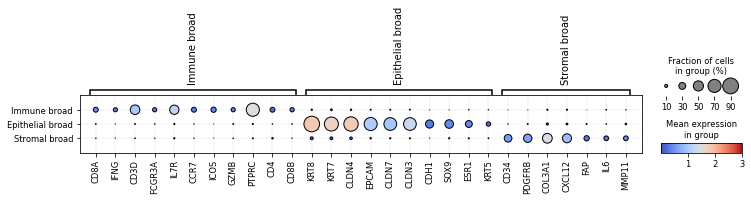

In [8]:
level = 'celltype_super'
categs_clustered = np.array(list(data.obs[level].unique()))[[1,2,0]] #np.array(list(data_sub.obs.celltype_major.cat.categories))[[0,4,7,8,2,5,1,3,6]]

dp = sc.pl.DotPlot(data, broad_markers, level, categories_order=categs_clustered, vmax=3)
dp.style(cmap='coolwarm', dot_edge_color='black', dot_edge_lw=1, grid=True, largest_dot=250)
dp.savefig(f'../figures/EDFig2B_marker_broad.pdf')

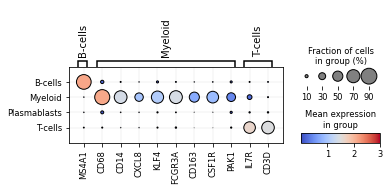

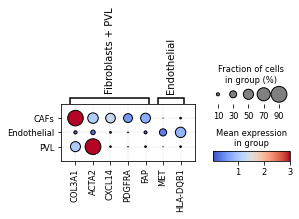

In [9]:
for k,v in condition.items():
    level = 'celltype_major'
    categs_clustered = np.array(list(data.obs.celltype_major.cat.categories))[[0,4,7,8,2,5,1,3,6]]
    
    data_sub = data[data.obs['celltype_super'] == k]
    categs_clustered = categs_clustered[np.isin(categs_clustered, data_sub.obs.celltype_major.unique())]
    
    dp = sc.pl.DotPlot(data_sub, {ks:narrow_markers[ks] for ks in v}, level, categories_order=categs_clustered, vmax=3)
    dp.style(cmap='coolwarm', dot_edge_color='black', dot_edge_lw=1, grid=True, largest_dot=250)
    dp.savefig(f'../figures/EDFig2B_marker_{k}_narrow.pdf')

## Annotating iss layers
Now, knowing the marker genes for the cell types of interest, we can annotate tissue slides. The simplest way to do this is to make a direct classificator based on the presence or absence of the ISS signal. To avoid confusion, we only look at the signals within 5um from the nearest nucleus.

Let's try this approach on the lymph node slide (LN1 imm)

In [10]:
from basiss.sc_annot import cell_type_decision, iss_annotation

In [11]:
result = iss_annotation(imm_sample_list_case2[2], broad_markers, narrow_markers, condition)

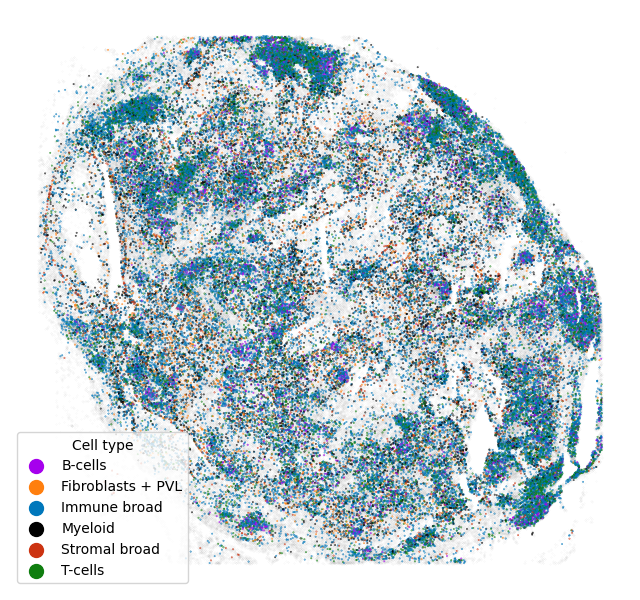

In [12]:
import matplotlib.pyplot as plt

cmap = {'Epithelial broad':(187,204,51,255), #green
        'Immune broad': (0,119,187,255), #blue
        'B-cells':(166, 0, 237, 255), #purple
        'Myeloid':(0,0,0,255),#(24, 217, 224, 255),
        'Stromal broad':(204,51,17,255), #red,
        'Endothelial':(210,180,140,255), #red,
        'T-cells':(15, 126, 15, 255), #tan
        'None':(0,0,0,10),
        'Fibroblasts + PVL':(255, 127, 14,255) 
        }
cmap = {k:tuple(np.array(cmap[k])/255) for k in cmap.keys()}


fig, ax = plt.subplots(figsize=[8, 8], dpi=100)

groups = result['nuclei_types'].groupby("assignment")
handles = []

xs = []
ys = []
cs = []
s = 0.1
name, group = 'None', groups.get_group('None')
ax.scatter(list(group["x"].values), list(group["y"].values), s=s, color=cmap[name])
for i, item in enumerate(groups):
    name, group = item
    if name == 'epithelial':
        h = ax.scatter([], [], label=name, color=cmap[name], s=100)
        handles.append(h)
        ax.scatter(list(group["x"].values), list(group["y"].values), s=s, color=cmap[name])
    elif name != 'None':
        h = ax.scatter([], [], label=name, color=cmap[name], s=100)
        handles.append(h)
        xs += list(group["x"].values)
        ys += list(group["y"].values)
        cs += [cmap[name]] * group["x"].shape[0]
pertrub = np.random.choice(np.arange(len(xs)), len(xs), replace=False)

ax.scatter(np.array(xs)[pertrub],
            np.array(ys)[pertrub],
            c=np.array(cs)[pertrub],
            s=s,
            rasterized=True)
ax.set_aspect('equal')
ax.invert_yaxis()
legend1 = plt.legend(loc='lower left', title='Cell type')
plt.axis('off');

As diplayed above, we managed to recover location of the main immune cell types - T-cells, B-cells and Myeloid. Interestingly B-cells are clusterd in the dense spots which look like germinal centres, while T-cells are located densly in the margins of the Lymph node. There're no Epithelial cells and Fibroblasts, as none of their marker genes are targeted in the immune panel. Therefore many of the unassigned nuclei (grey semitransparent) probably belong to them. 

Last step is to generate cell type maps for the rest of the slides: 

In [13]:
exp_sample_lists = exp_sample_list_case1 + exp_sample_list_case2
imm_sample_lists = imm_sample_list_case1 + imm_sample_list_case2

remove_list = ['background', 'nan', 'infeasible', 'PTPRC_trans5']
percentage_average = []
for i, sample_id in enumerate(['PD9694d', 'PD9694a', 'PD9694c', 'PD9694l', 'PD9694m', 'PD14780a', 'PD14780d', 'PD14780e']):
    for panel in ['expression', 'immune']:
        print(sample_id, panel)
        if panel == 'expression':
            result = iss_annotation(exp_sample_lists[i], broad_markers, narrow_markers, condition)
            
            iss_dat = pd.DataFrame(exp_sample_lists[i].data)
            iss_dat = iss_dat[exp_sample_lists[i].iss_probability > 0.6]
            iss_dat = iss_dat[~iss_dat.Gene.isin(remove_list)]

        if panel == 'immune':
            result = iss_annotation(imm_sample_lists[i], broad_markers, narrow_markers, condition)
            
            iss_dat = pd.DataFrame(imm_sample_lists[i].data)
            iss_dat = iss_dat[imm_sample_lists[i].iss_probability > 0.6]
            iss_dat = iss_dat[~iss_dat.Gene.isin(remove_list)]
        result['expression_per_nucleus'].to_csv(f'../submission/generated_data/sc_iss_annotations/{sample_id}_{panel}_expression_per_nucleus.csv')
        result['nuclei_types'].to_csv(f'../submission/generated_data/sc_iss_annotations/{sample_id}_{panel}_nuclei_annot.csv')
        
        iss_assigned = result['expression_per_nucleus']
        iss_assinged_number = iss_assigned[np.array(list(iss_assigned.columns))[~np.isin(iss_assigned.columns, remove_list)]].sum().sum()
        print(iss_assinged_number / iss_dat.shape[0])
        percentage_average.append(iss_assinged_number / iss_dat.shape[0])

PD9694d expression
0.5202135969573959
PD9694d immune
0.33543460349584997
PD9694a expression
0.5480589452078957
PD9694a immune
0.5343793898592595
PD9694c expression
0.6778317613375804
PD9694c immune
0.5787203080903104
PD9694l expression
0.7237818898220524
PD9694l immune
0.7696897611259788
PD9694m expression
0.718097296864523
PD9694m immune
0.7930707829922042
PD14780a expression
0.7530777403317181
PD14780a immune
0.8075010519068202
PD14780d expression
0.6654272031622156
PD14780d immune
0.6989101078399448
PD14780e expression
0.7688162229503781
PD14780e immune
0.8727596045289443
